In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from scipy.stats import lognorm
import scipy.stats as stats
from scipy.stats import norm
from scipy.optimize import minimize

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler        # untuk mengubah skala menjadi mean 0 dan deviasi standar 1

In [23]:
data = pd.read_csv("f:/Data D/TUGAS TH.4/TGA/ATAP/CSV/Rekap data/DATA KEAMANAN TUNGGAL")
data

,Panjang,Beban Tephra,Sudut,Aman Terhadap Penampang
0,6000,0.0,15,Aman
1,6000,0.0,20,Aman
2,6000,0.0,25,Aman
3,6000,0.0,30,Aman
4,6000,0.0,35,Aman
...,...,...,...,...
303,7500,1.0,25,Tidak Aman
304,7500,1.0,30,Tidak Aman
305,7500,1.0,35,Tidak Aman
306,7500,1.0,40,Tidak Aman


In [24]:
#Split data menjadi input dan output
X = data.iloc[:, [0, 1, 2]].values      # input
y = data.iloc[:, 3 ].values             # output

In [25]:
# Membagi data menjadi data train dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [26]:
#Scaling data
sc = StandardScaler() 
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [27]:
# Mengaktifkan fungsi classifikasi untuk KNN
knn = KNeighborsClassifier(n_neighbors=13)

In [28]:
# Membuat model berdasarkan data training
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=13)

In [29]:
# Prediksi label untuk data uji
y_pred = knn.predict(X_test)

print(accuracy_score(y_test, y_pred))
# rumus : TP + TN / (TP + TN + FP + FN)

0.967741935483871


In [30]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
cm

# 15 : Jumlah data 'aman' yang diprediksi dengan benar oleh model
# 15 : Jumlah data 'tidak aman' yang diprediksi dengan benar oleh model
# 0   : Jumlah data 'aman' yang salah diprediksi sebagai 'tidak aman' oleh model
# 1 : Jumlah data 'tidak aman' yang salah diprediksi sebagai 'aman' oleh model

array([[15,  0],
       [ 1, 15]], dtype=int64)

In [31]:
print(knn.predict(sc.transform([[6000, 1.5, 15]])))

['Tidak Aman']


In [32]:
#Prediksid data baru

tephra = []
Sudut = []
Panjang = []
CFSR = []

for panjang in range (6000, 7501, 100):
    for beban_tephra in range (1, 51, 1):
        beban_tephra = beban_tephra/50    
        for sudut in range (15, 46, 1):

            tephra.append(beban_tephra)
            Sudut.append(sudut)
            Panjang.append(panjang)
            CFSR.append(knn.predict(sc.transform([[panjang, beban_tephra, sudut]])))

data ={
    'Panjang' : Panjang,
    'Beban Tephra': tephra,
    'Sudut' : Sudut,
    'Aman Terhadap Penampang' : CFSR
} 

data = pd.DataFrame(data)

print(data)

       Panjang  Beban Tephra  Sudut Aman Terhadap Penampang
0         6000          0.02     15                  [Aman]
1         6000          0.02     16                  [Aman]
2         6000          0.02     17                  [Aman]
3         6000          0.02     18                  [Aman]
4         6000          0.02     19                  [Aman]
...        ...           ...    ...                     ...
24795     7500          1.00     41            [Tidak Aman]
24796     7500          1.00     42            [Tidak Aman]
24797     7500          1.00     43            [Tidak Aman]
24798     7500          1.00     44            [Tidak Aman]
24799     7500          1.00     45            [Tidak Aman]

[24800 rows x 4 columns]


In [33]:
data.to_csv('f:/Data D/TUGAS TH.4/TGA/ATAP/DATA ML/DATA HASIL KNN.csv')
print(data)

       Panjang  Beban Tephra  Sudut Aman Terhadap Penampang
0         6000          0.02     15                  [Aman]
1         6000          0.02     16                  [Aman]
2         6000          0.02     17                  [Aman]
3         6000          0.02     18                  [Aman]
4         6000          0.02     19                  [Aman]
...        ...           ...    ...                     ...
24795     7500          1.00     41            [Tidak Aman]
24796     7500          1.00     42            [Tidak Aman]
24797     7500          1.00     43            [Tidak Aman]
24798     7500          1.00     44            [Tidak Aman]
24799     7500          1.00     45            [Tidak Aman]

[24800 rows x 4 columns]


In [34]:
# Function to perform optimization and plotting for each damage state
def plot_fragility_curve(IM, damaged_roof, total_roof, label, color, IM_range):
    # Convert data to binomial
    y = damaged_roof / total_roof
    # Define the neg-loglik function
    def neg_loglik(theta):
        mu = theta[0]
        sigma = theta[1]
        prob = norm.cdf((np.log(IM) - mu) / sigma)
        ll = y * np.log(prob) + (1 - y) * np.log(1 - prob)
        return -np.sum(ll)

    # Perform optimization to estimate the parameters
    theta_start = np.array([0, 1])
    
    res = minimize(neg_loglik, theta_start, method='Nelder-Mead')

    mu_hat, sigma_hat = res.x
    
    # Calculate fragility curve
    p_collapse_range = norm.cdf((np.log(IM_range) - mu_hat) / sigma_hat)

    data ={
    'Beban Tephra' : IM_range,
    'Probability': p_collapse_range,
    }

    data= pd.DataFrame(data)
    print(data)

    csvdata = pd.DataFrame(data)
    csvdata.to_csv("f:/Data D/TUGAS TH.4/TGA/ATAP/DATA ML/EXCEL KURVA KERENTANAN KNN MLE.csv", index=False)

    # Plotting the fragility curve
    plt.plot(IM_range, p_collapse_range, label=f'{label} (mu={mu_hat:.2f}, sigma={sigma_hat:.2f})', color=color)

    plt.title('Lognormal CDF Vulnerability Curves using MLE')
    plt.xlabel('Tephra (kPa)')
    plt.ylabel('P[Collapse]')
    plt.legend()
    plt.grid(True)
    plt.savefig('f:/Data D/TUGAS TH.4/TGA/ATAP/DATA ML/KURVA KERENTANAN KNN MENGGUNAKAN MLE.png')
 
    return p_collapse_range, mu_hat, sigma_hat
    

In [35]:
# Generate IM values for fragility curve
x = np.linspace(0, 1.0, 50)

In [36]:
Tephra = data['Beban Tephra'].unique()

print("Beban Tephra:", Tephra)

Beban Tephra: [0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26 0.28
 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54 0.56
 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82 0.84
 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.  ]


In [37]:
total_roof = data['Beban Tephra'].value_counts().sort_values().values
print(total_roof)

[496 496 496 496 496 496 496 496 496 496 496 496 496 496 496 496 496 496
 496 496 496 496 496 496 496 496 496 496 496 496 496 496 496 496 496 496
 496 496 496 496 496 496 496 496 496 496 496 496 496 496]


In [38]:
damaged_roof = []
for beban in Tephra:
    # Filter the DataFrame for the current load
    filtered_data = data[data['Beban Tephra'] == beban]
    
    # Check if the current speed appears more than once
    count_tidak_aman = (filtered_data['Aman Terhadap Penampang'] == 'Tidak Aman').sum()

    damaged_roof.append(count_tidak_aman)  
    
data ={
'Beban Tephra' : Tephra,
'Damaged Roof': damaged_roof,
}

data= pd.DataFrame(data)
print(data)

csvdata = pd.DataFrame(data)
csvdata.to_csv("f:/Data D/TUGAS TH.4/TGA/ATAP/DATA ML/Damaged Roof KNN MLE", index=False)

    Beban Tephra  Damaged Roof
0           0.02             0
1           0.04             0
2           0.06             0
3           0.08             0
4           0.10             0
5           0.12             0
6           0.14             0
7           0.16             0
8           0.18             0
9           0.20             0
10          0.22             0
11          0.24             2
12          0.26             7
13          0.28            23
14          0.30            28
15          0.32            45
16          0.34            59
17          0.36            84
18          0.38            94
19          0.40           117
20          0.42           140
21          0.44           171
22          0.46           209
23          0.48           253
24          0.50           269
25          0.52           324
26          0.54           358
27          0.56           413
28          0.58           430
29          0.60           445
30          0.62           462
31      

In [39]:
# Given data for each damage state
IM_DS1 = np.array(Tephra)
damaged_roof = np.array(damaged_roof)
total_roof = np.array(total_roof)

    Beban Tephra   Probability
0       0.000000  0.000000e+00
1       0.020408  4.489276e-48
2       0.040816  7.779362e-30
3       0.061224  2.933181e-21
4       0.081633  4.156297e-16
5       0.102041  1.209561e-12
6       0.122449  3.710251e-10
7       0.142857  2.704746e-08
8       0.163265  7.397312e-07
9       0.183673  1.003125e-05
10      0.204082  8.084723e-05
11      0.224490  4.381613e-04
12      0.244898  1.742692e-03
13      0.265306  5.421737e-03
14      0.285714  1.384054e-02
15      0.306122  3.007265e-02
16      0.326531  5.722888e-02
17      0.346939  9.757704e-02
18      0.367347  1.518165e-01
19      0.387755  2.187874e-01
20      0.408163  2.956805e-01
21      0.428571  3.786157e-01
22      0.448980  4.633612e-01
23      0.469388  5.459858e-01
24      0.489796  6.233111e-01
25      0.510204  6.931293e-01
26      0.530612  7.542161e-01
27      0.551020  8.062017e-01
28      0.571429  8.493720e-01
29      0.591837  8.844530e-01
30      0.612245  9.124175e-01
31      

C:\Users\HP\AppData\Local\Temp\ipykernel_5524\2486562746.py:10: RuntimeWarning: divide by zero encountered in log
  ll = y * np.log(prob) + (1 - y) * np.log(1 - prob)
C:\Users\HP\AppData\Local\Temp\ipykernel_5524\2486562746.py:10: RuntimeWarning: invalid value encountered in multiply
  ll = y * np.log(prob) + (1 - y) * np.log(1 - prob)
C:\Users\HP\AppData\Local\Temp\ipykernel_5524\2486562746.py:21: RuntimeWarning: divide by zero encountered in log
  p_collapse_range = norm.cdf((np.log(IM_range) - mu_hat) / sigma_hat)


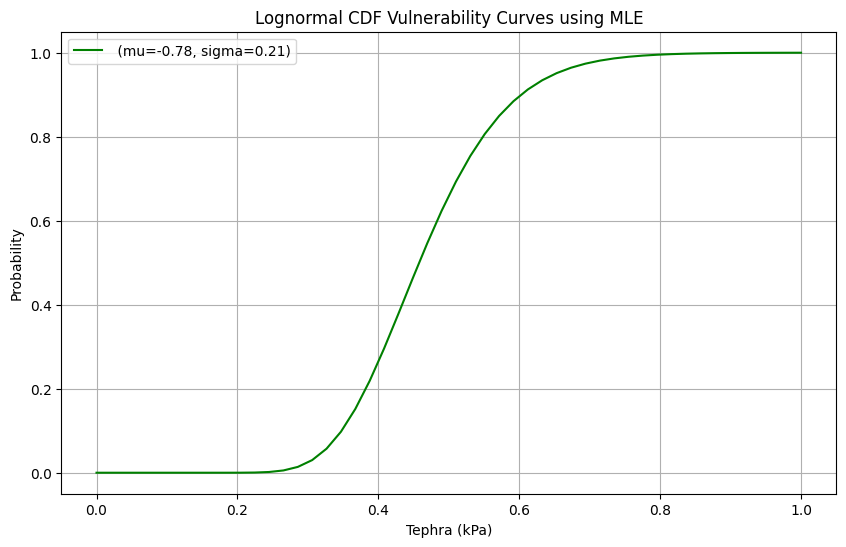

In [40]:
# Plotting
plt.figure(figsize=(10, 6))
plot_fragility_curve(IM_DS1, damaged_roof, total_roof, '', 'Green', x)

plt.title('Lognormal CDF Vulnerability Curves using MLE')
plt.xlabel('Tephra (kPa)')
plt.ylabel('Probability')
plt.legend()
plt.grid(True)
plt.show()